In [1]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from sklearn.model_selection import train_test_split

from settings.config import Config
from utils import prepare_labels, set_seed, get_transfrom, collate_fn, RSNA_Dataset, imshow, show_grid

import warnings
warnings.filterwarnings('ignore')

In [8]:
# download data

In [2]:
df = pd.read_csv(Config.train_data_labels)
print(f'Number of patients records: {df.shape[0]}')
print(f'Number of unique parients: {df["patientId"].unique().shape[0]}')
df

Number of patients records: 30227
Number of unique parients: 26684


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1


We can see that thera are couples of patients that have more then 1 records. Or in another words, they have more then 1 boxes on their images. Also replace NaN's with zeros. Let's prepare our labels table a bit and group corresponding boxes and labels together.

In [3]:
df = prepare_labels(df)
df.to_csv(Config.train_data_labels_preprocessed)
df = df.reset_index()
df

,patientId,boxes,labels
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,"([1.0, 1.0, 2.0, 2.0],)","(0,)"
1,000924cf-0f8d-42bd-9158-1af53881a557,"([1.0, 1.0, 2.0, 2.0],)","(0,)"
2,000db696-cf54-4385-b10b-6b16fbb3f985,"([316.0, 318.0, 486.0, 796.0], [660.0, 375.0, ...","(1, 1)"
3,000fe35a-2649-43d4-b027-e67796d412e0,"([570.0, 282.0, 839.0, 691.0], [83.0, 227.0, 3...","(1, 1)"
4,001031d9-f904-4a23-b3e5-2c088acd19c6,"([66.0, 160.0, 439.0, 768.0], [552.0, 164.0, 9...","(1, 1)"
...,...,...,...
26679,fffb2395-8edd-4954-8a89-ffe2fd329be3,"([177.0, 285.0, 402.0, 814.0], [641.0, 473.0, ...","(1, 1)"
26680,fffba05a-1635-4545-9bbd-57ad4cfe8d27,"([1.0, 1.0, 2.0, 2.0],)","(0,)"
26681,fffc95b5-605b-4226-80ab-62caec682b22,"([1.0, 1.0, 2.0, 2.0],)","(0,)"
26682,fffcff11-d018-4414-971a-a7cefa327795,"([1.0, 1.0, 2.0, 2.0],)","(0,)"


Datasets sizes:
	Train:  21347
	Valid:  5337
--------------------------------------------------

Train dataset transformation:  Compose(
)
Valid dataset transformation:  Compose(
)
--------------------------------------------------


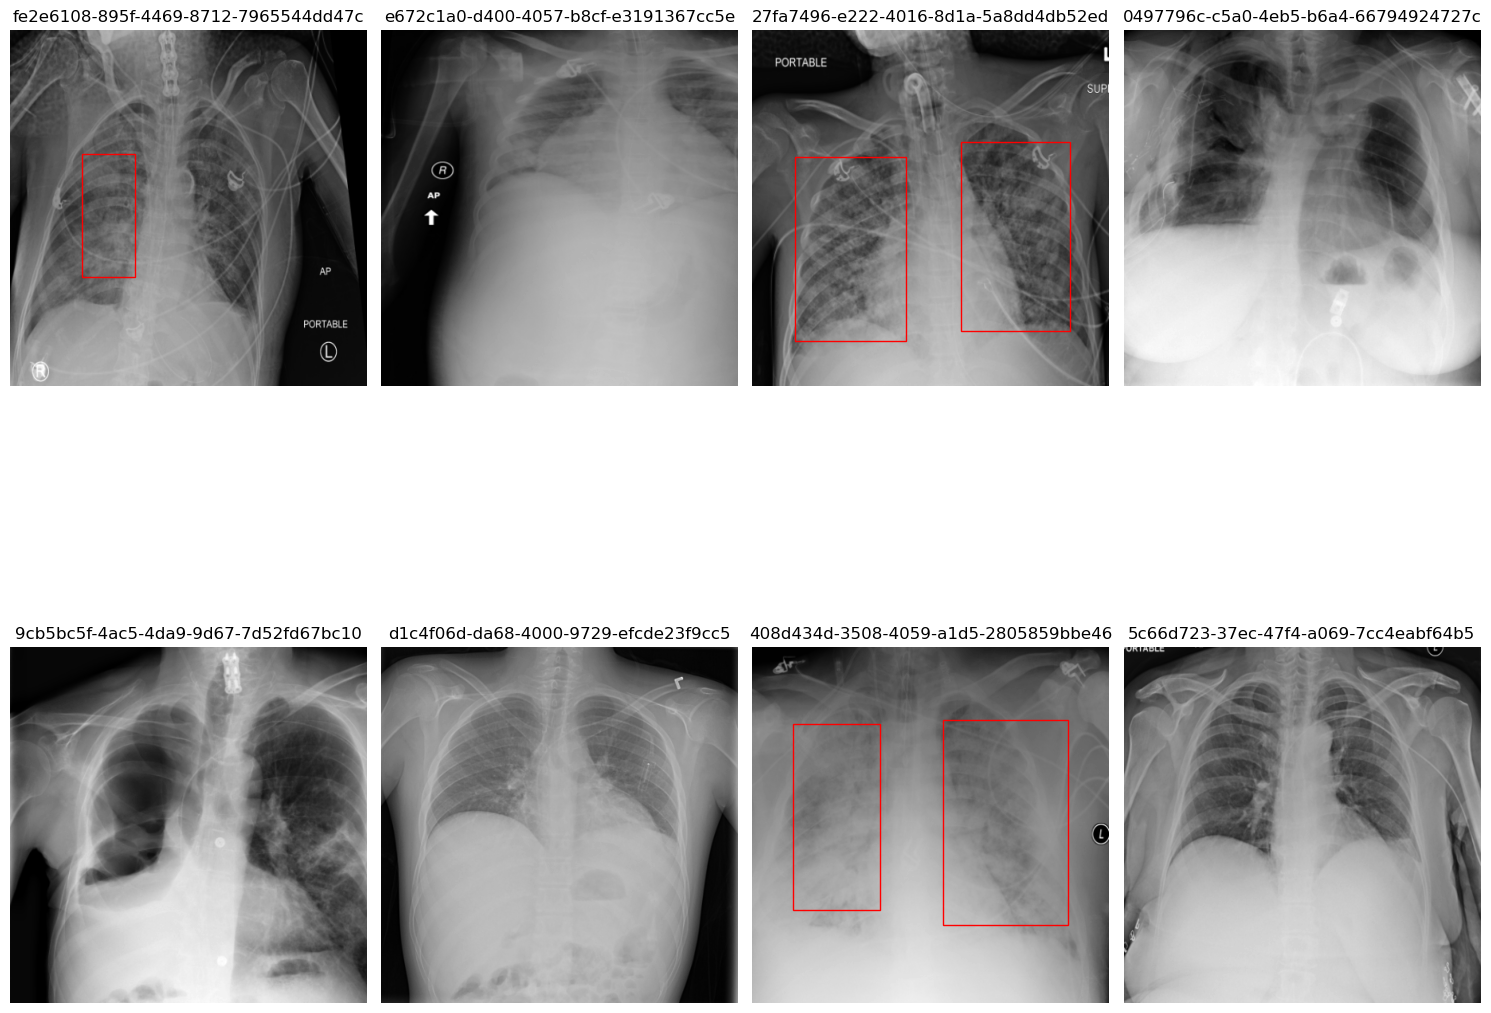

In [4]:
# set random seed to be able reprobuce results
set_seed(Config.seed)

# split data on dev and train subsets
train, valid = train_test_split(df, test_size=Config.valid_fraction, random_state=Config.seed)
# show datasets shapes
print('Datasets sizes:')
print('\tTrain: ', train.shape[0])
print('\tValid: ', valid.shape[0])
print('-' * 50)
print()
# create dict of datasets
datasets = {name: RSNA_Dataset(data, get_transfrom(name)) for name, data in zip(['train', 'valid'], [train, valid])}
# create dict of dataloaders
dataloaders = {x: DataLoader(datasets[x], batch_size=Config.batch_size, shuffle=True, num_workers=Config.num_workers, collate_fn=collate_fn) for x in ['train', 'valid']}

# show data transformations for train and dev subsets
print('Train dataset transformation: ', get_transfrom('train'))
print('Valid dataset transformation: ', get_transfrom('valid'))
print('-' * 50)

# get one batch of data
imgs, targets = next(iter(dataloaders['train']))
# plot some original examples with transformation and localisation boxes
show_grid(imgs, targets, title=True)

For this task we have to guarantee good accuracy of our prediction as it touches human health. In order to accomplish that, we will be using Two-stage Image Detecitons algorythms, they provide much better perfomance in compare to Single-stage ones like YOLO or SDD, but take much more time to train and predict. Nevertheless, speed is not important metrics for us this time.

So here we will fine-tune already pre-trained Faster R-CNN model.

In [5]:
# laod pre-trained model on COCO dataset
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(witghts='COCO_V1')
# froze parameters of the model to prevent training
for param in model.parameters():
    param.requires_grad = False
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, Config.num_classes)

In [6]:
from utils.engine import train_one_epoch, evaluate

def train(model, optimizer, train_loader, valid_loader,
          num_epochs=Config.epochs, valid_loss_min=np.inf, device=Config.device):
    model.to(device)
    
    for e in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, train_loader, device, e, print_freq=10)
        # update the learning rate
        #lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, valid_loader, device=device)
        
        

In [7]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
train(model, optimizer, dataloaders['train'], dataloaders['valid'])

Epoch: [0]  [   0/2669]  eta: 2:01:31  lr: 0.000010  loss: 173.1786 (173.1786)  loss_classifier: 163.2464 (163.2464)  loss_box_reg: 0.9701 (0.9701)  loss_objectness: 5.2102 (5.2102)  loss_rpn_box_reg: 3.7519 (3.7519)  time: 2.7321  data: 0.3166  max mem: 2171
Epoch: [0]  [  10/2669]  eta: 0:35:50  lr: 0.000060  loss: 16.2289 (38.0167)  loss_classifier: 4.3000 (26.7277)  loss_box_reg: 0.5862 (0.5379)  loss_objectness: 5.2102 (5.3260)  loss_rpn_box_reg: 5.1141 (5.4250)  time: 0.8086  data: 0.0437  max mem: 2188
Epoch: [0]  [  20/2669]  eta: 0:31:26  lr: 0.000110  loss: 25.8006 (40.0940)  loss_classifier: 14.5560 (28.0877)  loss_box_reg: 0.3892 (0.4959)  loss_objectness: 5.4224 (5.4598)  loss_rpn_box_reg: 5.6863 (6.0506)  time: 0.6111  data: 0.0131  max mem: 2188
Epoch: [0]  [  30/2669]  eta: 0:29:50  lr: 0.000160  loss: 34.1274 (39.3496)  loss_classifier: 21.3133 (27.4835)  loss_box_reg: 0.2638 (0.4300)  loss_objectness: 5.4224 (5.3555)  loss_rpn_box_reg: 5.7777 (6.0806)  time: 0.6068  d

KeyError: 'image_id'

In [ ]:
torch.save(model.state_dict(), 'model/model_weights.pth')
torch.save(model, 'model/model.pth')

In [ ]:
model = torch.load('model/model.pth')